In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
                            confusion_matrix, log_loss, precision_recall_curve, auc, classification_report

# **Machine Learning**

In [54]:
bank_df = pd.read_csv('../data/output/clean_bank_dataset.csv')

We drop the duration feature because it is only known after the call is completed, which causes data leakage; instead, our goal is to predict before calling so we can target customers who are more likely to participate.

Balance column converted to categorical column and is_participated column converted to binary column.

In [55]:
bank_df = bank_df.drop(['balance', 'is_participated', 'duration'], axis = 1)

In [56]:
bank_df['y'].value_counts(normalize= True) * 100

y
0    88.30152
1    11.69848
Name: proportion, dtype: float64

In [57]:
x = bank_df.drop('y' , axis=1)
y = bank_df['y']

### **<span style="color:#006699">1. Train/Test Split:</span>**

In [58]:
x_train , x_test , y_train , y_test = train_test_split(x, y, 
                                                        test_size=0.2,       
                                                        random_state=42, 
                                                        stratify=y)           #Because outcome is imbalance

In [59]:
y_test.value_counts()

y
0    7985
1    1058
Name: count, dtype: int64

In [60]:
y_train.value_counts()

y
0    31937
1     4231
Name: count, dtype: int64

The outcome of dataset is imbalance, 11% is for yes value and 88% for no, so balance split is needed for model selection.

### **<span style="color:#006699">2. Feature Engineering:</span>**

#### Numerical Column Scaling

In [61]:
train_num_cols = x_train[['age', 'day', 'campaign', 'pdays', 'previous']]
test_num_cols = x_test[['age', 'day', 'campaign', 'pdays', 'previous']]

num_scaler = StandardScaler()
x_train_num = num_scaler.fit_transform(train_num_cols)
x_test_num = num_scaler.transform(test_num_cols)

#### Categorical Columns Scaling

In [62]:
#one-hot method
train_cat_cols = x_train[[col for col in x_train.columns if col not in train_num_cols.columns.tolist() + ['balance_category','education']]]
test_cat_cols = x_test[[col for col in x_test.columns if col not in test_num_cols.columns.tolist() + ['balance_category','education']]]

cat_scaler = OneHotEncoder()
x_train_cat = cat_scaler.fit_transform(train_cat_cols)
x_test_cat = cat_scaler.transform(test_cat_cols)

In [63]:
#Label method for balance column 
ordinal_cols = ['balance_category']

# Define the order for each column
balance_order = ['in_debt', 'low', 'medium', 'high']

ordinal_encoder = OrdinalEncoder(categories=[balance_order])

x_train_ordinal = ordinal_encoder.fit_transform(x_train[ordinal_cols])
x_test_ordinal = ordinal_encoder.transform(x_test[ordinal_cols])

# Scale the encoded ordinal columns
scaler = StandardScaler()
x_train_ordinal_scaled = scaler.fit_transform(x_train_ordinal)
x_test_ordinal_scaled = scaler.transform(x_test_ordinal)

x_train.update(x_train_ordinal_scaled)
x_test.update(x_test_ordinal_scaled)

In [64]:
#Label method for education column because there is 'unknown' value which does not order in this column

#x_train
edu_col = x_train['education'].copy()
edu_known = edu_col.replace('unknown', np.nan)

education_order = ['primary', 'secondary', 'tertiary']
ordinal_encoder = OrdinalEncoder(categories=[education_order])

edu_encoded = ordinal_encoder.fit_transform(edu_known.dropna().to_frame())

edu_final = edu_col.copy()
edu_final[edu_final != 'unknown'] = edu_encoded
edu_final[edu_final == 'unknown'] = -1

edu_final = edu_final.astype(float)

scaler = StandardScaler()
x_train_edu = scaler.fit_transform(edu_final.to_frame()) 


#x_test 
edu_test = x_test['education'].copy()

edu_test_encoded = edu_test.copy()

mask_known = edu_test_encoded != 'unknown'

edu_test_encoded.loc[mask_known] = ordinal_encoder.transform(edu_test_encoded[mask_known].to_frame()).ravel()

edu_test_encoded.loc[edu_test_encoded == 'unknown'] = -1

edu_test_encoded = edu_test_encoded.astype(float)

x_test_edu = scaler.transform(edu_test_encoded.to_frame())

#### Combine All Scaled Columns and Convert to Dataframe

In [65]:
num_cols = ['age', 'day', 'campaign', 'pdays', 'previous']
ordinal_cols = ['balance_category']
edu_col = ['education_scaled']   # اسم جدید برای education

# Dense features
X_train_dense_df = pd.DataFrame(
    np.hstack([x_train_num, x_train_ordinal_scaled, x_train_edu]),
    columns=num_cols + ordinal_cols + edu_col,
    index=x_train.index
)

X_test_dense_df = pd.DataFrame(
    np.hstack([x_test_num, x_test_ordinal_scaled, x_test_edu]),
    columns=num_cols + ordinal_cols + edu_col,
    index=x_test.index
)

In [66]:
cat_cols = cat_scaler.get_feature_names_out(train_cat_cols.columns)
X_train_cat_df = pd.DataFrame(x_train_cat.toarray(), columns=cat_cols, index=x_train.index)
X_test_cat_df = pd.DataFrame(x_test_cat.toarray(), columns=cat_cols, index=x_test.index)

In [67]:
X_train_final = pd.concat([X_train_dense_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_dense_df, X_test_cat_df], axis=1)

### **<span style="color:#006699">3. Create model (Logistic Regression):</span>**

In [68]:
#Create Model
log_model = LogisticRegression(max_iter=1000, random_state=42)

In [69]:
#Find best model with gridsearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       
    'penalty': ['l1', 'l2'],             
    'class_weight': ['balanced', None],  
    'solver': ['liblinear']              
}

grid_log = GridSearchCV(LogisticRegression(max_iter=1000),
                    param_grid, 
                    scoring='recall',  
                    cv=3,              
                    n_jobs=-1)

In [70]:
#Fit Model
grid_log.fit(X_train_final, y_train)

,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced', None], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [71]:
#Predict outcome
y_pred_train_log = grid_log.predict(X_train_final)
y_pred_test_log = grid_log.predict(X_test_final)

y
0    31937
1     4231
Name: count, dtype: int64


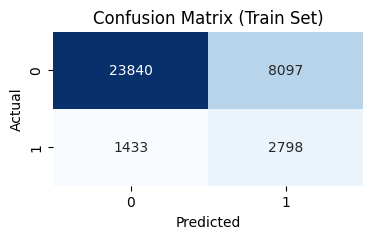

In [72]:
print(y_train.value_counts())
cm = confusion_matrix(y_train, y_pred_train_log)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

y
0    7985
1    1058
Name: count, dtype: int64


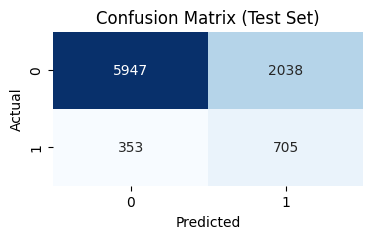

In [73]:
print(y_test.value_counts())
cm = confusion_matrix(y_test, y_pred_test_log)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

#### Evaluating Model

In [103]:
def evaluate_model(model, x_test, y_test, y_pred=None, threshold = 0.3):
    
    has_proba = hasattr(model, "predict_proba")
    y_prob = None

    if has_proba:
        y_prob = model.predict_proba(x_test)[:, 1]
        y_pred_threshold = (y_prob >= threshold).astype(int)
        if y_pred is None:
            y_pred = y_pred_threshold
    else:
        if y_pred is None:
            y_pred = model.predict(x_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_prob) if has_proba else None    
    logloss = log_loss(y_test, y_prob) if has_proba else None

    # Precision-Recall AUC
    if has_proba:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
    else:
        pr_auc = None

    metrics_summary = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'LogLoss': logloss
    }
    return pd.DataFrame(metrics_summary, index=[0])

In [75]:
log_metrics = evaluate_model(grid_log, X_test_final, y_test, y_pred= y_pred_test_log, threshold= 0.3)
log_metrics

,Accuracy,Precision,Recall,F1-Score,Specificity,ROC-AUC,PR-AUC,LogLoss
0,0.735597,0.257018,0.666352,0.370955,0.744771,0.773931,0.405137,0.559894


### **<span style="color:#006699">4. Create model (KNN):</span>**

In [76]:
#Create model
knn_model = KNeighborsClassifier()

In [77]:
#Find best model with gridsearch
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

grid_knn = GridSearchCV(knn_model,
                    param_grid,
                    scoring='recall',
                    cv=5,
                    n_jobs=-1)

In [78]:
#Fit model
grid_knn.fit(X_train_final, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['minkowski', 'euclidean', ...], 'n_neighbors': [1, 3, ...], 'weights': ['uniform', 'distance']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,1


In [79]:
#Prediction
y_pred_train_knn = grid_knn.predict(X_train_final)
y_pred_test_knn = grid_knn.predict(X_test_final)

y
0    31937
1     4231
Name: count, dtype: int64


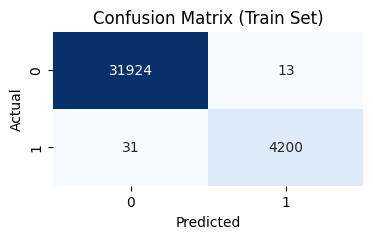

In [80]:
print(y_train.value_counts())
cm = confusion_matrix(y_train, y_pred_train_knn)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

y
0    7985
1    1058
Name: count, dtype: int64


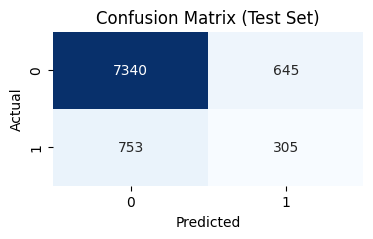

In [81]:
print(y_test.value_counts())
cm = confusion_matrix(y_test, y_pred_test_knn)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [82]:
knn_metrics = evaluate_model(grid_knn, X_test_final, y_test, y_pred= y_pred_test_knn, threshold=0.3)
knn_metrics

,Accuracy,Precision,Recall,F1-Score,Specificity,ROC-AUC,PR-AUC,LogLoss
0,0.845405,0.321053,0.28828,0.303785,0.919224,0.603752,0.346301,5.572158


In [83]:
threshold = 0.5
y_prob = grid_knn.predict_proba(X_test_final)[:, 1]  # probability for positive class
y_pred_threshold = (y_prob >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_knn)
TN, FP, FN, TP = cm.ravel()

# Metrics calculation
accuracy = accuracy_score(y_test, y_pred_test_knn)
precision = precision_score(y_test, y_pred_test_knn)
recall = recall_score(y_test, y_pred_test_knn)
f1 = f1_score(y_test, y_pred_test_knn)
specificity = TN / (TN + FP)
roc_auc = roc_auc_score(y_test, y_pred_threshold)
logloss = log_loss(y_test, y_pred_threshold)

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_threshold)
pr_auc = auc(recall_vals, precision_vals)

metrics_summary = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc,
    'LogLoss': logloss
}

metrics_df = pd.DataFrame(metrics_summary, index=[0])
metrics_df

,Accuracy,Precision,Recall,F1-Score,Specificity,ROC-AUC,PR-AUC,LogLoss
0,0.845405,0.321053,0.28828,0.303785,0.919224,0.603752,0.346301,5.572158


### **<span style="color:#006699">5. Create model (Random Forrest):</span>**

In [86]:
#Create model
rf_model = RandomForestClassifier(random_state=42)

In [87]:
#Find best model with gridsearch
params_rf = {"n_estimators" : [80 , 100 , 120] ,
             "max_depth" : [9 , 13 ,19] ,
             "min_samples_split" : [2 , 4 , 7 ,9]
             }
grid_rf = GridSearchCV(rf_model,
                        params_rf,
                        scoring='recall',
                        cv=5,
                        n_jobs=-1)

In [89]:
#Fit model
grid_rf.fit(X_train_final, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [9, 13, ...], 'min_samples_split': [2, 4, ...], 'n_estimators': [80, 100, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,80


In [90]:
#Prediction
y_pred_train_rf = grid_rf.predict(X_train_final)
y_pred_test_rf = grid_rf.predict(X_test_final)

y
0    31937
1     4231
Name: count, dtype: int64


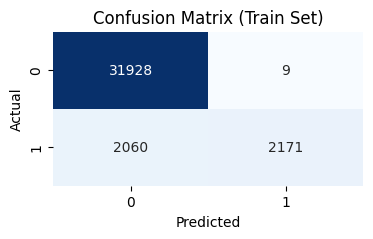

In [91]:
print(y_train.value_counts())
cm = confusion_matrix(y_train, y_pred_train_rf)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

y
0    7985
1    1058
Name: count, dtype: int64


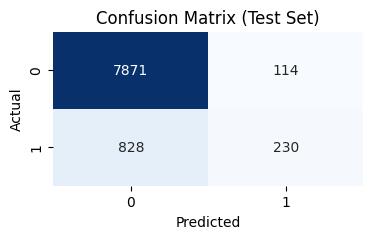

In [92]:
print(y_test.value_counts())
cm = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [107]:
rf_metrics = evaluate_model(grid_rf, X_test_final, y_test, y_pred= y_pred_test_rf, threshold=0.3)
rf_metrics

,Accuracy,Precision,Recall,F1-Score,Specificity,ROC-AUC,PR-AUC,LogLoss
0,0.895831,0.668605,0.217391,0.328103,0.985723,0.797291,0.444809,0.286498


### **<span style="color:#006699">6. Create model (SVM):</span>**

In [94]:
# #Create model
svm_model = SVC()

In [95]:
#Fit model
svm_model.fit(X_train_final, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [96]:
#Prediction
y_pred_train_svm = svm_model.predict(X_train_final)
y_pred_test_svm = svm_model.predict(X_test_final)

y
0    31937
1     4231
Name: count, dtype: int64


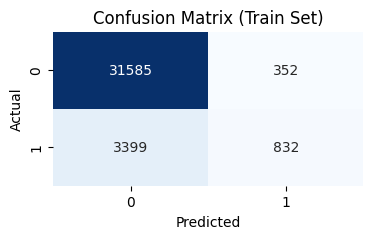

In [97]:
print(y_train.value_counts())
cm = confusion_matrix(y_train, y_pred_train_svm)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

y
0    31937
1     4231
Name: count, dtype: int64


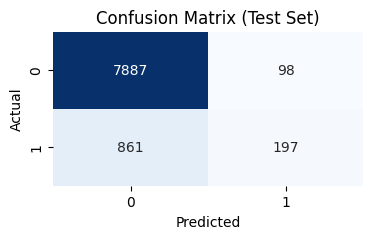

In [98]:
print(y_train.value_counts())
cm = confusion_matrix(y_test, y_pred_test_svm)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [104]:
svm_metrics = evaluate_model(svm_model, X_test_final, y_test, y_pred= y_pred_test_svm, threshold=0.3)
svm_metrics

,Accuracy,Precision,Recall,F1-Score,Specificity,ROC-AUC,PR-AUC,LogLoss
0,0.893951,0.667797,0.1862,0.291205,0.987727,None,None,None


### **<span style="color:#006699">Final Result:</span>**

After evaluating several models, the **logistic regression** model correctly **identifies 70% of the test data**, while the other models showed unsatisfactory performance.
Since the goal of this modeling is to identify participating customers for targeted outreach, the logistic model can be considered useful. However, further optimization is needed to improve its accuracy and reliability.

The logistic model increases Recall, meaning it successfully captures the majority of actual campaign participants. Although Precision and overall Accuracy decrease, this is acceptable because the main objective is to focus marketing efforts on those most likely to respond.